Progetto: **Classificazione di testi descrittivi per destinazione d'uso, inerenti ai beni sottoposti ad aste giudiziarie italiane.**

Studente: **Alessandro Monolo** | *10439147*

Relatore: Marco Brambilla

Referente aziendale: Simone Redaelli

Master: Data Science & Artificial Intelligence

Università: Politecnico di Milano

<hr style="border:1px solid black">


## Categorizzazione dei testi tokenizzati utilizzando modelli di classificazione

- Link Tutorial per questo script: https://github.com/PradipNichite/Youtube-Tutorials/blob/main/Yotutube_WordVectors.ipynb


- **Per la classificazione dei testi, in questo caso le descrizioni testuali dei beni in asta erano appartenenti a due data set:**
    - Il **primo**, ha subito una **successiva fase di preprocessing**, riducendo le stringhe univoche presenti a circa **39.000 unità**, ed avendo **eliminato tutte le cifre in esse**. Il testo è rimasto lemmatizzato.
    - Mentre il **secondo è il medesimo utilizzato per tfidf o BoW**, contenente ancora le cifre e le parole non comuni non droppate.


- **A. Tokenizzazione del testo con l'utilizzo del modello di Spacy "it_core_news_sm", per la lingua italiana;**


- **B. Vettorializzazione del testo con Word2Vec.**
    - Per la Vettorializzazione con Word2Vec è stato impiegato nello specifico il seguente modello pretrainato: "**fasttext-wiki-news-subwords-300**".


- **1.** **<u>Stratified K-Fold + Word2Vec + Support Vector Machine model:</u>**


- **2.** **<u>Stratified K-Fold + Word2Vec + Logisti Regression classifier model:</u>**    


- **3.** **<u>Stratified K-Fold + Word2Vec + XGBoost Classifier:</u>**   


- **4.** **<u>Conclusioni.</u>**


<hr style="border:1px solid black">

**Importo le librerie che mi servono:**

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image
import string
import unicodedata
from sklearn.model_selection import train_test_split
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import fasttext
from sklearn.model_selection import StratifiedKFold, cross_val_score
import spacy
import gensim
from tqdm import tqdm
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api
from sklearn import metrics
from sklearn.metrics import classification_report, precision_score, f1_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

#### Set pandas options:

In [3]:
pd.set_option('display.max_colwidth', None)
pd.options.display.max_rows = 5000
pd.options.display.max_columns = 1000
pd.options.display.float_format = '{:.4f}'.format
pd.options.mode.chained_assignment = None

### Importo file CSV:

- **Senza cifre e con typos:**

In [4]:
#df = pd.read_csv("D:\\Master_Cefriel_DS_AI_Monolo\\0_Project_Work\\Dataset\\13_Dataset_FastText\\Dataset_FastText.csv")

- **con ancora cifre e typo:**

In [5]:
df = pd.read_csv("D:\\Master_Cefriel_DS_AI_Monolo\\0_Project_Work\\Dataset\\11_Dataset_TFIDF_LR_&_SVM\\Dataset_TFIDF_LR_&_SVM.csv")

<hr style="border:1px solid black">

### A - Tokenizzazione del testo con la libreria Spacy
- Impiegando il modello "**it_core_news_sm**".

In [6]:
nlp = spacy.load('it_core_news_sm')

def spacy_tokenizer_italian(sentence):
    doc = nlp(sentence)
    mytokens = [token.text for token in doc]
    return mytokens

df['Descrizione_Bene_Lemm_Spacy'] = df['Descrizione_Bene_Lemm_Spacy'].astype(str)
tqdm.pandas()
df['tokens'] = df['Descrizione_Bene_Lemm_Spacy'].progress_apply(spacy_tokenizer_italian)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 166003/166003 [20:47<00:00, 133.03it/s]


### B - Vettorializzazione del testo con Word2Vec:
- Importo tramite API la libreria Word2Vec, specificando il tipo di tokenizer, in questo caso: "**fasttext-wiki-news-subwords-300**";
- Questo modello è addestrato su un ampio corpus di articoli di Wikipedia e include informazioni sui sottotipi di parole. Può essere una buona scelta per l'incorporamento di parole a scopo generale in diverse lingue, compreso l'**italiano**.

In [24]:
# Questi sono tutti i modelli disponibili:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [7]:
wv = api.load('fasttext-wiki-news-subwords-300')

In [8]:
def sent_vec(sent):
    vector_size = wv.vector_size
    wv_res = np.zeros(vector_size)
    ctr = 1
    for w in sent:
        if w in wv:
            ctr += 1
            wv_res += wv[w]
    wv_res = wv_res/ctr
    return wv_res

tqdm.pandas()
df['vec'] = df['tokens'].progress_apply(sent_vec)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 166003/166003 [00:17<00:00, 9575.21it/s]


<hr style="border:1px solid black">

### 1 - Stratified K - Fold + Word2Vec + Support Vector Machine

In [9]:
X_1 = np.array(df['vec'].to_list())
y_1 = np.array(df["Destinazione_Uso_Encoded"].to_list())

folds_1 = StratifiedKFold(n_splits=5)

score_precision_1 = []
score_f1_1 = []
score_recall_1 = []

all_test_indices_1 = []
all_predictions_1 = []

for train_index_1, test_index_1 in folds_1.split(X_1, y_1):
    X_train_1, X_test_1, y_train_1, y_test_1 = X_1[train_index_1], X_1[test_index_1], y_1[train_index_1], y_1[test_index_1]
    
    clf = LinearSVC()
    clf.fit(X_train_1, y_train_1)
    svm_predictions = clf.predict(X_test_1)
    
    precision_1 = precision_score(y_test_1, svm_predictions, average='macro', zero_division=0)
    recall_1 = recall_score(y_test_1, svm_predictions, average='macro', zero_division=0)
    f1_1 = f1_score(y_test_1, svm_predictions, average='macro', zero_division=0)    

    score_precision_1.append(precision_1)
    score_recall_1.append(recall_1)
    score_f1_1.append(f1_1)
    
    all_test_indices_1.extend(test_index_1)
    all_predictions_1.extend(svm_predictions)

mean_precision_1 = np.mean(score_precision_1)
mean_recall_1 = np.mean(score_recall_1)
mean_f1_1 = np.mean(score_f1_1)    

classification_report_str_1 = classification_report(y_1, all_predictions_1, zero_division=1)

print("Classification Report, averaged over all folds:\n")
print(classification_report_str_1, "\n")
print("Precision:", round(mean_precision_1, 2))
print("Recall:", round(mean_recall_1, 2))
print("F1-Score:", round(mean_f1_1, 2))

Classification Report, averaged over all folds:

              precision    recall  f1-score   support

           0       1.00      0.00      0.00       550
           1       0.59      0.02      0.03       560
           2       0.20      0.00      0.00      2269
           3       0.34      0.22      0.27      5801
           4       0.81      0.97      0.88    132176
           5       0.29      0.08      0.13      7743
           6       0.30      0.04      0.07     16904

    accuracy                           0.79    166003
   macro avg       0.51      0.19      0.20    166003
weighted avg       0.71      0.79      0.73    166003
 

Precision: 0.57
Recall: 0.25
F1-Score: 0.28


- **Con il testo senza le cifre: Precision: 0.53, Recall: 0.26.**
- L'**F1 score** ottenuta con **SVM** sulla variabile testuale tokenizzata e vettorializzata è pari a **0.29**;
- Molto bassa l'F1 score relativa alle **categorie 0, 1, 2 e 6**


- Di conseguenza, le **metriche di valutazione per entrambi** i data set utilizzati, non cambia di molto, raggiungendo in entrambi i casi una **f1 score di 0.28 e 0.29 punti**.

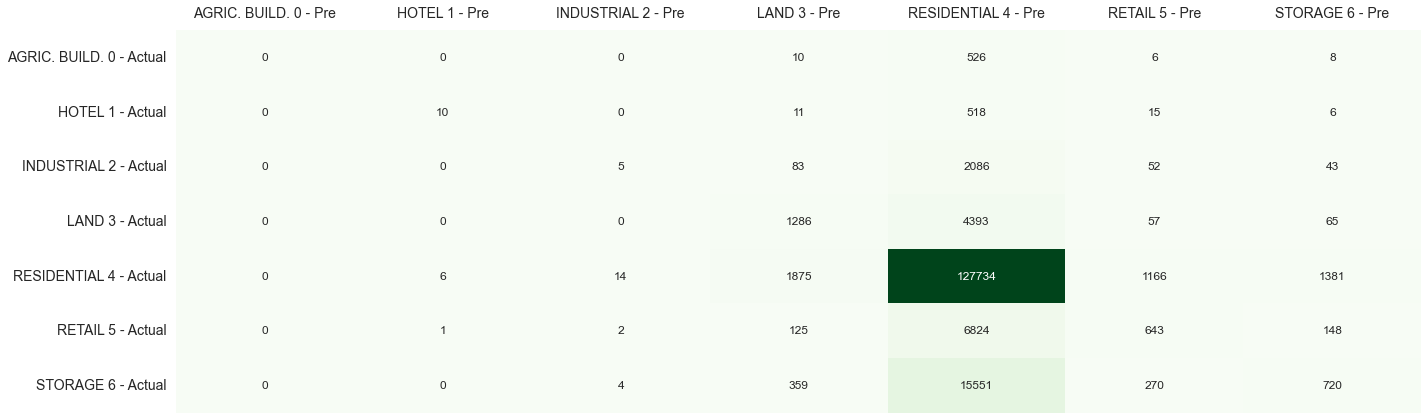

In [21]:
cm_pred_1 = confusion_matrix(y_1, all_predictions_1)
cm_pred_1 = pd.DataFrame(cm_pred_1,
                       index=['AGRIC. BUILD. 0 - Actual','HOTEL 1 - Actual','INDUSTRIAL 2 - Actual','LAND 3 - Actual','RESIDENTIAL 4 - Actual','RETAIL 5 - Actual','STORAGE 6 - Actual'],
                       columns = ['AGRIC. BUILD. 0 - Pre','HOTEL 1 - Pre','INDUSTRIAL 2 - Pre','LAND 3 - Pre','RESIDENTIAL 4 - Pre','RETAIL 5 - Pre','STORAGE 6 - Pre'])

# Mostro la confusion matrix su una heatmap:
sns.set(rc={'figure.figsize':(20,6)})
heatmap = sns.heatmap(cm_pred_1, 
            annot=True, 
            cmap="Greens", 
            fmt="d", 
            xticklabels=['AGRIC. BUILD. 0 - Pre','HOTEL 1 - Pre','INDUSTRIAL 2 - Pre','LAND 3 - Pre','RESIDENTIAL 4 - Pre','RETAIL 5 - Pre','STORAGE 6 - Pre'], 
            yticklabels=['AGRIC. BUILD. 0 - Actual','HOTEL 1 - Actual','INDUSTRIAL 2 - Actual','LAND 3 - Actual','RESIDENTIAL 4 - Actual','RETAIL 5 - Actual','STORAGE 6 - Actual'],
                     cbar=False)

heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=14)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=14)

plt.tick_params(axis='x', labeltop=True, labelbottom=False)
plt.tight_layout()
plt.show()

In [18]:
print("Numero predizioni corrette: ", 10+5+1286+127734+643+720)
print("Numero predizioni sbagliate: ", 166003-(10+5+1286+127734+643+720))

Numero predizioni corrette:  130398
Numero predizioni sbagliate:  35605


- **Con il testo senza le cifre: Numero predizioni corrette:  130336, Numero predizioni sbagliate:  35667.**


- In generale si denota un **distribuzione degli errori più accentuata sulle classi inerenti ai beni**:
    - 0 (**Agricultural Building**);
    - 1 (**Hotel**);
    - 2 (**Industrial**);
    - 6 (**Storage**);


- Mentre i **parametri migliori** sono stati raggiunti nelle **categorie dei beni appartenenti** a:
    - 3 (**Land**);
    - 4 (**Residential**);
    - 5 (**Retail**);
    

- Anche in questo caso, il **numero di errori complessivi non cambia di molto**, prima erano **35667**, mentre ora sono **35605**.

<hr style="border:1px solid black">

### 2 - Stratified K - Fold + Word2Vec + Logistic Regression

In [12]:
X_2 = np.array(df['vec'].to_list())
y_2 = np.array(df["Destinazione_Uso_Encoded"].to_list())

folds_2 = StratifiedKFold(n_splits=5)

score_precision_2 = []
score_f1_2 = []
score_recall_2 = []

all_test_indices_2 = []
all_predictions_2 = []

for train_index_2, test_index_2 in folds_2.split(X_2, y_2):
    X_train_2, X_test_2, y_train_2, y_test_2 = X_2[train_index_2], X_2[test_index_2], y_2[train_index_2], y_2[test_index_2]
    
    classifier = LogisticRegression()
    classifier.fit(X_train_2,y_train_2)
    lg_predictions = classifier.predict(X_test_2)
    
    precision_2 = precision_score(y_test_2, lg_predictions, average='macro', zero_division=0)
    recall_2 = recall_score(y_test_2, lg_predictions, average='macro', zero_division=0)
    f1_2 = f1_score(y_test_2, lg_predictions, average='macro', zero_division=0)    

    score_precision_2.append(precision_2)
    score_recall_2.append(recall_2)
    score_f1_2.append(f1_2)
    
    all_test_indices_2.extend(test_index_2)
    all_predictions_2.extend(lg_predictions)

mean_precision_2 = np.mean(score_precision_2)
mean_recall_2 = np.mean(score_recall_2)
mean_f1_2 = np.mean(score_f1_2)    

classification_report_str_2 = classification_report(y_2, all_predictions_2, zero_division=1)

print("Classification Report, averaged over all folds:\n")
print(classification_report_str_2, "\n")
print("Precision:", round(mean_precision_2, 2))
print("Recall:", round(mean_recall_2, 2))
print("F1-Score:", round(mean_f1_2, 2))

Classification Report, averaged over all folds:

              precision    recall  f1-score   support

           0       1.00      0.00      0.00       550
           1       1.00      0.00      0.00       560
           2       0.20      0.01      0.03      2269
           3       0.37      0.23      0.28      5801
           4       0.81      0.97      0.88    132176
           5       0.26      0.07      0.11      7743
           6       0.28      0.04      0.07     16904

    accuracy                           0.78    166003
   macro avg       0.56      0.19      0.20    166003
weighted avg       0.71      0.78      0.72    166003
 

Precision: 0.44
Recall: 0.25
F1-Score: 0.27


- **Con il testo senza le cifre: Precision: 0.44, Recall: 0.25.**
- La situazione relativa ad **F1 Score non cambia**, risulta sempre essere bassa anche in questo caso, essendo pari a **0.28**.
- Le **medesime interpretazioni** valgono per le **singole classi predette**.

- La **F1 Score è anche in questo caso inferiore di 1 punto** rispetto a quella ottenuta con l'utilizzo del data set senza cifre.

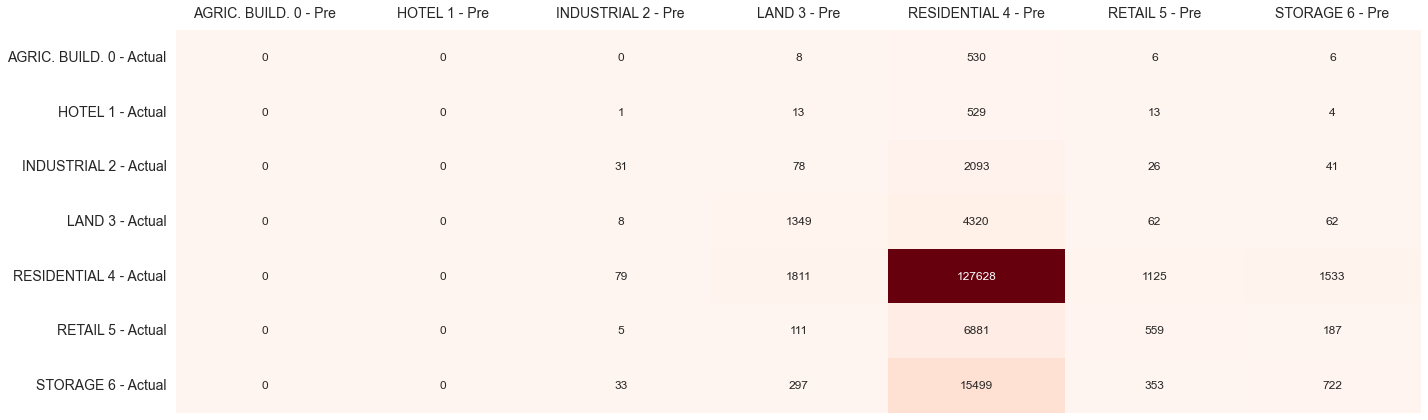

In [22]:
cm_pred_2 = confusion_matrix(y_2, all_predictions_2)
cm_pred_2 = pd.DataFrame(cm_pred_2,
                       index=['AGRIC. BUILD. 0 - Actual','HOTEL 1 - Actual','INDUSTRIAL 2 - Actual','LAND 3 - Actual','RESIDENTIAL 4 - Actual','RETAIL 5 - Actual','STORAGE 6 - Actual'],
                       columns = ['AGRIC. BUILD. 0 - Pre','HOTEL 1 - Pre','INDUSTRIAL 2 - Pre','LAND 3 - Pre','RESIDENTIAL 4 - Pre','RETAIL 5 - Pre','STORAGE 6 - Pre'])

# Mostro la confusion matrix su una heatmap:
sns.set(rc={'figure.figsize':(20,6)})
heatmap = sns.heatmap(cm_pred_2, 
            annot=True, 
            cmap="Reds", 
            fmt="d", 
            xticklabels=['AGRIC. BUILD. 0 - Pre','HOTEL 1 - Pre','INDUSTRIAL 2 - Pre','LAND 3 - Pre','RESIDENTIAL 4 - Pre','RETAIL 5 - Pre','STORAGE 6 - Pre'], 
            yticklabels=['AGRIC. BUILD. 0 - Actual','HOTEL 1 - Actual','INDUSTRIAL 2 - Actual','LAND 3 - Actual','RESIDENTIAL 4 - Actual','RETAIL 5 - Actual','STORAGE 6 - Actual'],
                     cbar=False)

heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=14)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=14)

plt.tick_params(axis='x', labeltop=True, labelbottom=False)
plt.tight_layout()
plt.show()

In [19]:
print("Numero predizioni corrette: ", 31++1349+127628+559+722)
print("Numero predizioni sbagliate: ", 166003-(31++1349+127628+559+722))

Numero predizioni corrette:  130289
Numero predizioni sbagliate:  35714


- **Con il testo senza le cifre: Numero predizioni corrette:  130309, Numero predizioni sbagliate:  35694.**
- Anche in questo caso, come prima, il numero di errori predetti è di circa 35 mila osservazioni.

- Difatti, anche in questo caso il **numero di errori predetti è aumentato rispetto a prima**, arrivando a **35714**, dove prima invece erano **35694**.

<hr style="border:1px solid black">

### 3 - Stratified K - Fold + Word2Vec + XGBoost Classifier

In [15]:
X_3 = np.array(df['vec'].to_list())
y_3 = np.array(df["Destinazione_Uso_Encoded"].to_list())

folds_3 = StratifiedKFold(n_splits=5)

score_precision_3 = []
score_f1_3 = []
score_recall_3 = []

all_test_indices_3 = []
all_predictions_3 = []

for train_index_3, test_index_3 in folds_3.split(X_3, y_3):
    X_train_3, X_test_3, y_train_3, y_test_3 = X_3[train_index_3], X_3[test_index_3], y_3[train_index_3], y_3[test_index_3]
    
    xgb_model = xgb_classifier = xgb.XGBClassifier(
        scale_pos_weight=0.2,  
        learning_rate=0.1,  
        n_estimators=100,  
        max_depth=3,  
        min_child_weight=1, 
        gamma=0.1,  
        subsample=0.8, 
        reg_alpha=0, 
        reg_lambda=1  
)
    xgb_model.fit(X_train_3, y_train_3)
    xgb_predictions = xgb_model.predict(X_test_3)

    precision_3 = precision_score(y_test_3, xgb_predictions, average='macro', zero_division=0)
    recall_3 = recall_score(y_test_3, xgb_predictions, average='macro', zero_division=0)
    f1_3 = f1_score(y_test_3, xgb_predictions, average='macro', zero_division=0)

    score_precision_3.append(precision_3)
    score_recall_3.append(recall_3)
    score_f1_3.append(f1_3)

    all_test_indices_3.extend(test_index_3)
    all_predictions_3.extend(xgb_predictions)

mean_precision_3 = np.mean(score_precision_3)
mean_recall_3 = np.mean(score_recall_3)
mean_f1_3 = np.mean(score_f1_3)

classification_report_str_3 = classification_report(y_3, all_predictions_3, zero_division=0)

print("Classification Report, averaged over all folds:\n")
print(classification_report_str_3, "\n")
print("Precision:", round(mean_precision_3, 2))
print("Recall:", round(mean_recall_3, 2))
print("F1-Score:", round(mean_f1_3, 2))

Classification Report, averaged over all folds:

              precision    recall  f1-score   support

           0       1.00      0.00      0.01       550
           1       0.33      0.00      0.00       560
           2       0.20      0.01      0.03      2269
           3       0.35      0.21      0.26      5801
           4       0.81      0.96      0.88    132176
           5       0.26      0.07      0.11      7743
           6       0.29      0.05      0.09     16904

    accuracy                           0.78    166003
   macro avg       0.46      0.19      0.20    166003
weighted avg       0.71      0.78      0.72    166003
 

Precision: 0.53
Recall: 0.25
F1-Score: 0.28


- **Con il testo senza le cifre: Precision: 0.56, Recall: 0.25.**
- La situazione relativa ad **F1 Score non cambia**, risulta sempre essere bassa anche in questo caso, essendo pari a **0.28**.
- Le **medesime interpretazioni** valgono per le **singole classi predette**.

- In questo caso, utilizzando xgboost classifier, l'**F1 score rimane identico rispetto a prima**.

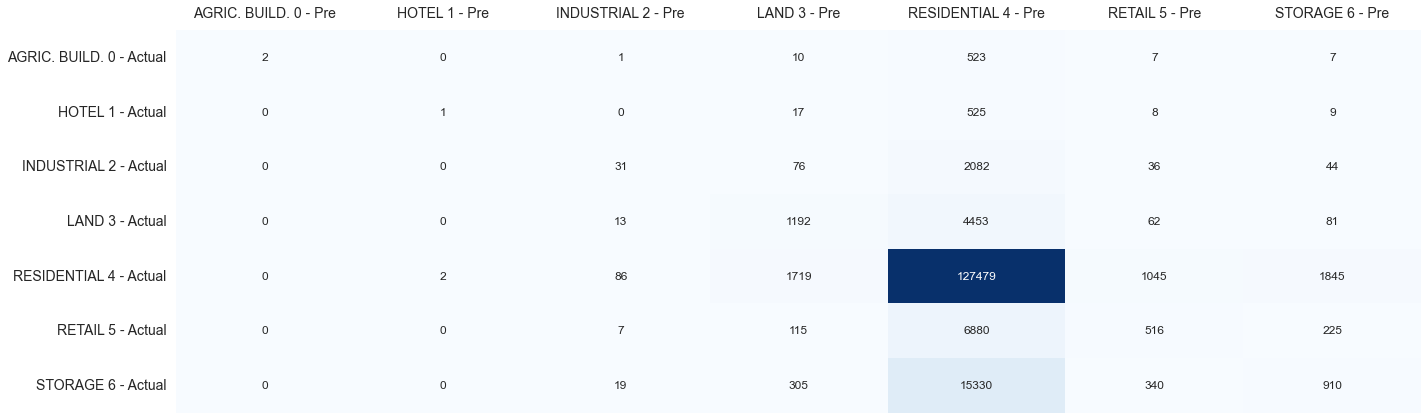

In [16]:
cm_pred_3 = confusion_matrix(y_3, all_predictions_3)
cm_pred_3 = pd.DataFrame(cm_pred_3,
                       index=['AGRIC. BUILD. 0 - Actual','HOTEL 1 - Actual','INDUSTRIAL 2 - Actual','LAND 3 - Actual','RESIDENTIAL 4 - Actual','RETAIL 5 - Actual','STORAGE 6 - Actual'],
                       columns = ['AGRIC. BUILD. 0 - Pre','HOTEL 1 - Pre','INDUSTRIAL 2 - Pre','LAND 3 - Pre','RESIDENTIAL 4 - Pre','RETAIL 5 - Pre','STORAGE 6 - Pre'])

# Mostro la confusion matrix su una heatmap:
sns.set(rc={'figure.figsize':(20,6)})
heatmap = sns.heatmap(cm_pred_3, 
            annot=True, 
            cmap="Blues", 
            fmt="d", 
            xticklabels=['AGRIC. BUILD. 0 - Pre','HOTEL 1 - Pre','INDUSTRIAL 2 - Pre','LAND 3 - Pre','RESIDENTIAL 4 - Pre','RETAIL 5 - Pre','STORAGE 6 - Pre'], 
            yticklabels=['AGRIC. BUILD. 0 - Actual','HOTEL 1 - Actual','INDUSTRIAL 2 - Actual','LAND 3 - Actual','RESIDENTIAL 4 - Actual','RETAIL 5 - Actual','STORAGE 6 - Actual'],
                     cbar=False)

heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=14)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=14)

plt.tick_params(axis='x', labeltop=True, labelbottom=False)
plt.tight_layout()
plt.show()

In [20]:
print("Numero predizioni corrette: ", 2+1+31+1192+127479+516+910)
print("Numero predizioni sbagliate: ", 166003-(2+1+31+1192+127479+516+910))

Numero predizioni corrette:  130131
Numero predizioni sbagliate:  35872


- **Con il testo senza le cifre: Numero predizioni corrette:  130037, Numero predizioni sbagliate:  35966.**

- Infine, il **numero di predizioni errate** in questo caso d**iminuisce** arrivando a **35872**, dove prima erano **35966** unità.

<hr style="border:1px solid black">

### 4 - Conclusioni

- **1.1 - Stratified K - Fold + Spacy & Word2Vec + Support Vector Machine model con testo senza cifre:**
    -  <u>F1-Score: **0.28</u>** 
    -  Numero predizioni corrette:  **130.398**
    -  <u>Numero predizioni sbagliate:  **35.605</u>**
- **1.2 - Stratified K - Fold + Spacy & Word2Vec + Support Vector Machine model con testo con cifre:**
    -  F1-Score: **0.28**
    -  Numero predizioni corrette:  **130.336**
    -  Numero predizioni sbagliate:  **35.667**
    

- **2.1 - Stratified K - Fold + Spacy & Word2Vec + Logistic regression model con testo senza cifre:**
    -  F1-Score: **0.27**
    -  Numero predizioni corrette:  **130.289**
    -  Numero predizioni sbagliate:  **35.714**
- **2.2 - Stratified K - Fold + Spacy & Word2Vec + Logistic regression model con testo con cifre:**
    -  F1-Score: **0.28**
    -  Numero predizioni corrette:  **130.309**
    -  Numero predizioni sbagliate:  **35.694**
    
    
- **3.1 - Stratified K - Fold + Spacy & Word2Vec + XGBoost Classifier Model con testo senza cifre:**
    -  F1-Score: **0.28**
    -  Numero predizioni corrette:  **130.131**
    -  Numero predizioni sbagliate:  **35.872**
- **3.2 - Stratified K - Fold + Spacy & Word2Vec + XGBoost Classifier Model con testo con cifre:**
    -  F1-Score: **0.28**
    -  Numero predizioni corrette:  **130.037**
    -  Numero predizioni sbagliate:  **35.966**
    
<hr style="border:1px solid black">


#### In conclusione


- L'utilizzo di una **variabile testuale che non presenta cifre e typos al proprio interno, non influenza sull'effettiva quantità di errori in fase di predizione**. Difatti, l'F1 Score rimane invariato in quasi tutte le combinazioni.


- La **soluzione migliore** in questo caso risulta essere la combinazione data da **Spacy + Word2Vec insieme a Support Vector Machine**, registrando una **F1 Score** pari a **0.28**, con un **numero complessivo di errori registrati in fase di predizione** pari a: **35.605**.


- **Si deduce quindi**, mettendo a paragone con le altre combinazioni precedenti, che la soluzione prevista in questo script, con l'**utilizzo di Spacy e Word2Vec come tokenizzazione e vettorializazione, risulta essere inferiore alle altre proposte precedenti**, in special modo quella registrata con **TFIDF**, la quale risulta ancora la **soluzione che registra l'F1 score più alta**, raggiunta dal modello **SVM utilizzato con la variabile lemmatizzata**, pari a **0.56**;